# **AM 207**: Homework 2

Verena Kaynig-Fittkau and Pavlos Protopapas  <br>
**Due: 11.59 P.M. Thursday March 3rd, 2015**

### Instructions:

+ Upload your answers in an ipython notebook to Canvas.

+ We will provide you imports for your ipython notebook. Please do not import additional libraries.

+ Your individual submissions should use the following filenames: AM207_YOURNAME_HW2.ipynb

+ Your code should be in code cells as part of your ipython notebook. Do not use a different language (or format). 

+ **Do not just send your code. The homework solutions should be in a report style. Be sure to add comments to your code as well as markdown cells where you describe your approach and discuss your results. **

+ Please submit your notebook in an executed status, so that we can see all the results you computed. However, we will still run your code and all cells should reproduce the output when executed. 

+ If you have multiple files (e.g. you've added code files or images) create a tarball for all files in a single file and name it: AM207_YOURNAME_HW2.tar.gz or AM207_YOURNAME_HW2.zip


### Have Fun!
_ _ _ _ _

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")

import time
import timeit

import scipy.stats 
import pandas as pd
import pymc as pm

import re
import numpy as np

/home/kevin/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Problem 1: Geweke Convergence Test

In the lecture we have seen the Geweke test as one option to test for convergence of our metropolis hastings chain. Describe in your own words how the Geweke test works and its limitations. 

We provide you with the following code for the Geweke test. Write comments for the marked lines and any lines you think would be good to explain in addition. 

Write a short explanation of what the `rhot` function does and why it is necessary. 

The Geweke test compares the z-score (mean over scaled variance) of segments of a sampled distribution to determine if the samples reach the steady state of the Markov Chain. Intuitively, the earlier part of the samples need to be similar to the later part to demonstrate convergence. Nominally we take $\pm2$ standard deviation as our metric for convergence. The limitation of this method is that it cannot provide a proof for convergence. In addition, it is sensitive to the spectral distribution of the samples. 

Please refer to the comments below. 

The rhot function computes the correlation between symmetric parts of the input data. Ideally we want to input data to be independent. However, we know MCMC gives correlated sampels. The rhot function gives the correction factor for the correlated samples. If the input samples are truely independent, then the loop involving rhot returns 1. Mathematically, the z-score is given by: 

$z = \frac{\bar{\theta_a}-\bar{\theta_b}}{\sqrt{\frac{S(\theta_a)}{m}+\frac{S(\theta_b)}{n}}}$.

Here $S()$ is the scale variance.

In [2]:
# return the autocorrelation coefficient between symmetric parts of input data
# note x[0:(n-t)] , x[t:n] have equal length
def rhot(x, t):
    n = len(x)
    return np.corrcoef(x[0:(n-t)], x[t:n])[0,1]

# 
def Geweke(trace, intervals, length):
    nsl=length
    #step size to divide data into number of intervals(range from 10% to 100%)
    jump = int(0.9*len(trace)/(2*intervals))
    #start index of the 1st interval
    first = 0.1*len(trace)
    
    z =np.empty(intervals)
    #loop: compute the z-score for each interval
    for k in np.arange(0, intervals):
        # compute the start index of segment a
        baga = np.int(first+k*jump)
        # compute the start index of segment b
        bagb = len(trace)/2 + k*jump
        
        # obtain local segment a and b from the full data 'trace'
        sub_trace_a = trace[baga:baga+nsl]
        sub_trace_b = trace[bagb:bagb+nsl]
        
        # calculate the mean of segment a and b
        theta_a = np.mean(sub_trace_a)
        theta_b = np.mean(sub_trace_b)
        rho_a, rho_b = 1.0, 1.0
        # loop: loop through the pivoting indices for segment a and b
        for i in xrange(int(0.1*nsl)):
            # sum correlation coefficient of each symmetric parts of segment a and b
            rho_a += 2*rhot(sub_trace_a, i+1)
            rho_b += 2*rhot(sub_trace_b, i+1)
            
        # compute the scaled variance of segment a and b
        var_a  = np.var(sub_trace_a)*rho_a/length
        var_b  = np.var(sub_trace_b)*rho_b/length
        
        # compute the z-score of local segment a and b
        z[k] = (theta_a-theta_b)/np.sqrt( var_a + var_b)
    
    return z

#if __name__ == "main":
    


# Problem 2: Message Response Times

The file `hangout_chat_data.csv` contains the response times of your friend Mark to google hangout chat messages in seconds. Use a method of your choice to read the file into a data frame or a numpy array. Your goal for this problem is to model Mark's chat response time distribution in a Bayesian framework. 

The description of the data sounds like a Poisson distribution is a good choice for our likelihood. We have messages arriving independently of each other, and instead of the arrival time we consider the time it took Mark to respond to the messages. 

* Load and describe the data by plotting a histogram of the response times. 
* Derive and compute the maximum likelihood solution for a Poisson distribution.
* Compare this to the Bayesian solution with a prior of your choice and using your own implementation of Metropolis Hastings to sample from the posterior. Make sure to describe why you chose this prior, as well as the specifics of your Metropolis Hastings implementation. 

* Analyze your sampling using traceplots and convergence tests. You can use the Geweke implementation given above. 
* Compare your solution to a solution using the MCMC class in pymc and write a brief discussion. Which parameters does your implementation need that the pymc implementation can do without? How do the traceplots compare? 

* Check your ML solution and the Bayesian solution against the data. If you know how you can use the posterior predictive for the Bayesian solution, otherwise you can use the MAP estimate or the expectation value of the posterior and compare that distribution to the data histogram. 

* Was our model a good choice for this problem? If yes great, if not, come up with a different Bayesian model that is better capable of capturing the data and show that it works better. 


number of data is:  266
lambda* is : 18.0413533835


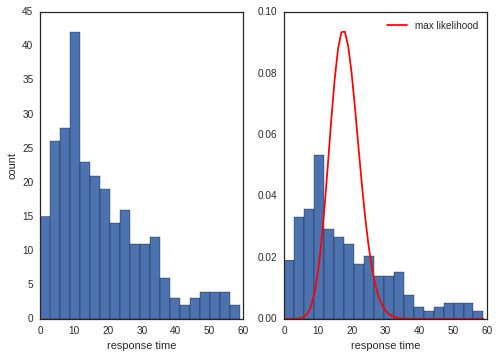

In [74]:
#load data from .csv file
data = np.genfromtxt('hangout_chat_data.csv',delimiter=',')

#print data.dtype
#assert(0)

#plot a histogram
plt.subplot(1,2,1)
plt.hist(data,bins=20)
plt.xlabel('response time')
plt.ylabel('count')

plt.subplot(1,2,2)
plt.hist(data,bins=20,normed=1)
plt.xlabel('response time')

#\lambda that corresponds to maximum likelihood is the mean 
l = np.mean(data)
print 'number of data is: ', len(data)
print 'lambda* is :', l

time_sim = np.linspace(np.min(data),np.max(data),60)
fact_terms = scipy.misc.factorial(time_sim)
p_sim = np.exp(-l) * l**time_sim / fact_terms
plt.plot(time_sim,p_sim,'r-',label = 'max likelihood')
plt.legend()


Maximum likelihood of the Poisson distribtuion

Here we derive the maximum likelihood for the Poisson distribution. We have 

$P(x_i)=\frac{e^{-\lambda}\lambda^{x_i}}{x_i!}$

The likelihood is given by:

$l = \prod_{i=1}^N \frac{e^{-\lambda}\lambda^{x_i}}{x_i!}$

Equivalently we can maximize log(l). We set the derivative to 0 and obtain:

$0 = \frac{\partial logl}{\partial \lambda} = \sum_{i=1}^N (-\lambda^* + x_i\log\lambda^* - \log (x_i!))$

Simplifying the expression leads to 

$\lambda^* = \frac{\sum_{i=1}^N x_i}{N}$

We simplify calculate the mean and obtain $\lambda^* = 18.04$

### Bayesian solution and Metropolis Hasting

We choose the prior to be a normal distribution: $p(\lambda) = N(\lambda,\sigma)$, where we set $\lambda = 18$ and $\sigma = 5$. This choice to motivated by the maximum likelihood result. Since we have a lot of data, the power of prior diminishes as N increases. 

The posterior has the form of $p(\lambda | D) \propto p(D | \lambda) p(\lambda)$. We use Metroplis Hasting to sample from the posterior. This algorithm does not require solving for the normalization factor. 




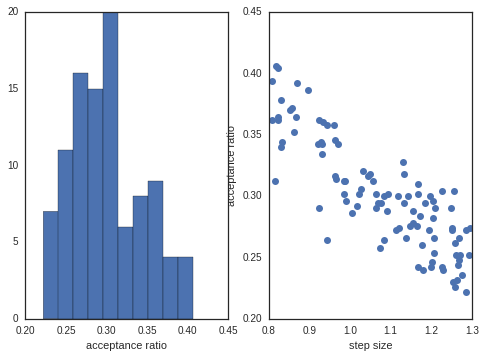

In [75]:
#metropolis hasting with a gaussian prior

#short hand for uniform random sampling
runif = np.random.rand
rnorm = np.random.normal
#short hand for normal distribution
norm = scipy.stats.norm

#define the posterior function
def calc_posterior(l,x=data):
    
    p = np.product(np.exp(-l)*l**x / scipy.misc.factorial(x) * norm.pdf(x,loc=18,scale=5))
    
    return p;

#calculate the log of the posterior
def calc_log_posterior(l,x=data):
    #print len(data)
    #print data.dtype
    #print data[0]
    #print x[0]
    #print x
    #assert(0)
    #print x*np.log(l)
    #print scipy.misc.factorial(x)
    #print np.log(scipy.misc.factorial(x))
    
    #assert(0)
    p = np.sum(-l + x * np.log(l) - np.log(scipy.misc.factorial(x)));
    #print 'debug: ', p
    return p;

def metropolis(n_iterations, init_values, step_size, doPrint = True):
    
    #determine number of parameters
    n_params = len(init_values)
    
    #initialize samples
    trace= np.empty((n_iterations+1,n_params))
    
    #set initial values
    trace[0] = init_values
    
    #calculate joint posterior for initial values
    current_prob = calc_log_posterior(*trace[0])
    
    #initialize acceptance counts
    accepted = [0]*n_params

    for i in xrange(n_iterations):
        
        if not i%10000 and doPrint:
            print 'Iterations left: ', n_iterations- i
            
        #Grab current parameter values
        current_params = trace[i]
        
        #get current value for parameter j
        p = trace[i].copy()
        
        #loop over all dimensions (here only 1 dimension)
        for j in range(n_params):
            #propose a new value
            theta = rnorm(current_params[j],step_size[j])

            #insert new value
            p[j]= theta
            
            #calculate posterior with proposed value
            #print 'input p is: ', p[j]
            proposed_prob = calc_log_posterior(*p)
            
            #acceptance rate
            alpha = proposed_prob - current_prob
            
            #sample a uniform function to determine whether to reject
            u = runif()
            
            #test proposed value
            #if (np.log(u)) < alpha:
            if u < np.exp(alpha):
                #Accept 
                trace[i+1,j]=theta
                current_prob = proposed_prob
                accepted[j] +=1
                
                #print 'u = ',u
                #print 'proposed= ', proposed_prob, 'cur = ', current_prob
                #print 'ratio = ',np.exp(alpha)
                
                
                
            else:
                #reject
                #print np.exp(alpha)
                trace[i+1,j] = trace[i,j]
                
            #update p 
            p[j] = trace[i+1,j]
            
    #print accepted
    #return samples and number of accepted steps
    return trace, accepted

#driver code to sample using metroplis-hasting and a normal prior
if __name__ =="__main__":
    n_iter = 500
    init_val = [12];
    acc_ratio = []
    step_size_vec = []
    
    for i in range(100):
        step_size = 0.8 + np.random.rand(1)*0.5 ;
        data = np.genfromtxt('hangout_chat_data.csv',delimiter=',')
        trace,acc = metropolis(n_iter,init_val,step_size,doPrint=False)
        acc_ratio.append(np.sum(acc)/np.float(n_iter))
        step_size_vec.append(step_size)
        
    acc_ratio = np.array(acc_ratio)
    
    plt.subplot(1,2,1)
    plt.hist(acc_ratio,bins=10)
    plt.xlabel('acceptance ratio')
    #print trace
    
    plt.subplot(1,2,2)
    plt.plot(step_size_vec,acc_ratio,'o')
    plt.xlabel('step size')
    plt.ylabel('acceptance ratio')
    #plot a histogram
    #plt.subplot(1,2,1)
    #plt.hist(data,bins=20)
    #plt.xlabel('response time')
    #plt.ylabel('count')

    #plt.subplot(1,2,1)
    #plt.hist(trace,bins=20,normed=True)
    #plt.xlabel('lambda')
    
    #plt.subplot(1,2,2)
    #plt.plot(trace)
    
    
    
    
    
    

# Problem 3: Markov Chains

* Given the following transition matrix, examine if the corresponding Markov Chain is irreducible and aperiodic. Note: No formal proof necessary, but you should give a solid argumentation.

$$ P = \left( 
\begin{array}{ccccc}
0.0 & 0.4 & 0.6 & 0.0 & 0.0 \\
0.65 & 0.0 & 0.35 & 0.0 & 0.0 \\
0.32 & 0.68 & 0.0 & 0.0 & 0.0 \\
0.0 & 0.0 & 0.0 & 0.12 & 0.88 \\
0.0 & 0.0 & 0.0 & 0.56 & 0.44 
\end{array}
\right ) $$



This Markov Chain is reducible and aperiodic. 

### Reducible ###
By definition, a markov chain is irreducible if the equivalence relation induces only 1 class (p195, Pinsky). This definition means every state must commute any other state. Formally, this is given by $P_{ij}^{(n)} > 0$ for some n. This Markov Chain has 2 equivalent classes. States 1 - 3 commute with each other but cannot transition to states 4-5. So if we start in state 1-3 we can never go into state 4 or 5. The reverse is also true. Hence, this problem has 2 equivalence classes, and hence it is reducible.

### Aperiodic ###
By definition, a markov chain is aperiodic if every state has period 1 (p198, Pinsky). We also invoke the theorem that states the periodicity of a state within an equivalence class is the same. Hence, we only need to analyze the periodicity of state 1 and 4. 

State 1 can return to itself in 2 steps (1->2->1)or 3 steps (1->2->3->1) or more. The g.c.d of {2,3...} is 1. Hence, state 1 has a periodicity of 1. Invoking the equivalence theorem state 2 and 3 also have period 1.

State 4 and 5 are much simpler. The transition probability among them are non-zeros. It's quiet straightforward to see the period of state 4 and 5 are 1. Consequently, every state has period of 1, so this Markov Chain is aperiodic. 

# Problem 4: The Evidence 

In lectures we mostly concentrate on the likelihood and the prior and regard the evidence as a mere normalization factor. However, the evidence can be quite useful. In this problem you will compare different models by computing the evidence for each model, aka the probability that randomly selected parameters from a given model class would generate the data $X$.

As our models we compare polynomials of degree 0 to 4. For example for degree 2 we have $y = a_0 + a_1 \cdot x + a_2 \cdot x^2 + \epsilon$ where $\epsilon \sim N(0, \sigma) $ and $\theta = [a_0, a_1, a_2, \sigma]$. Assume that for all polynomials $a_i \sim \text{Expo}(1)$ and $\sigma \sim \text{Inverse Gamma}(1,1)$.


Bayes' theorem states that:
$$
P(\theta|x)=\frac{P(x|\theta)P(\theta)}{P(x)}
$$
$P(\theta)$ is the prior, $P(x|\theta)$ is the likelihood, $P(x)$ is called the evidence, and $P(\theta|x)$ is the posterior.

Your tasks are:

* Write down the mathematical equation of the evidence in terms of the likelihood and the prior. You don't need to solve the integral analytically, just write down its formula.
* Now you have the evidence in the form of an integral. Solve it by using importance sampling. What is a good choice for your importance sampling distribution?
* Compare the evidence for polynomials of degree 0 to 4. Which polynomial wins?

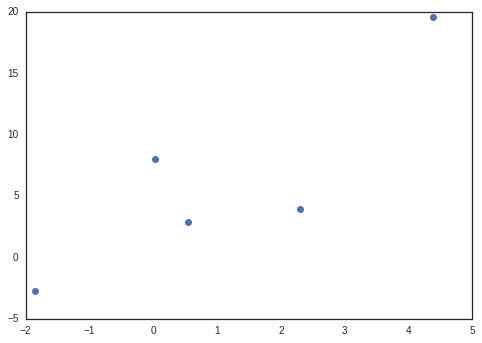

In [5]:
# Here is your data for the problem:
data = np.array([[ -1.85519254,  -2.7009541 ],
       [  4.38291824,  19.61735369],
       [  2.29495208,   3.96481822],
       [  0.02075668,   8.00646088],
       [  0.54097177,   2.8872262 ]])

x=data[:,0]
y=data[:,1]

plt.plot(x,y,'o')

### Mathematical equation of evidence
We can use law of total probability to obtain:

$ P(x) = \int_\Omega P(x|\theta)P(\theta) d\theta$, where $\theta \in \Omega$

Here we write out the mathematical form of normal distribution, exponential distribution and inverse gamma distribution. 

We have:

$Exp(1,x) = e^{-x} $

$inv\_gamma(1,1,x) = x^{-2} e^{-1/x}$

$N(\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{(x-\mu)^2}{2\sigma^2}} $

Substituting this expressions into P(x), we obtain

$P = \int_\Omega \Pi_jN(y_j - a_0 + a_1x_j + ... + a_ix_j^i \ |\ 0,\sigma) e^{-a_0-...a_i} \sigma^{-2}e^{-1/\sigma} d\sigma da_0 .. da_i$

(0, 10)

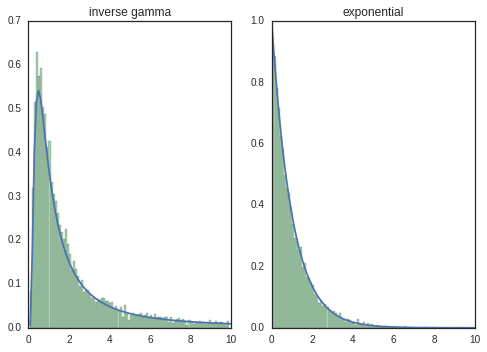

In [6]:
#define exponential(1)
def exponential_1(x):
    return np.exp(-x)

#define inverse gamma(1,1)
def inv_gamma_11(x):
    return x**(-2)*np.exp(-1/x)



xx = np.linspace(0,10,100)
y_ig = inv_gamma_11(xx)
y_ex = exponential_1(xx)

#sample from inverse gamma
plt.subplot(1,2,1)
plt.plot(xx,y_ig)
plt.title('inverse gamma')
y_sim_ig = scipy.stats.invgamma.rvs([1,],size=10000)
bins = np.arange(0,10,0.1)
plt.hist(y_sim_ig,bins,normed=True,alpha=0.5)
plt.xlim([0, 10])

#sample from exponential
plt.subplot(1,2,2)
plt.plot(xx,y_ex)
plt.title('exponential')
y_sim_ex = scipy.stats.expon.rvs(size=10000)
plt.hist(y_sim_ex,bins,normed=True,alpha=0.5)
plt.xlim([0, 10])

### integrate using importance sampling
We can integrate the function using importance sampling: 
$\int_\Omega f(\theta) d\theta = E_q [\frac{f(\theta)}{q(\theta)}]$, where the distribution $q(\theta)$ is normalized over $\Omega$. Here we can sample from the joint probability distribution:

$q(\theta)  = inv\_gamma(1,1,\sigma) \Pi_i exp(a_i)$

This choice of sampling function does not exactly approximate the function, but is normalized to 1. In addition, if we choose the prior as sampling distribution from the importane sampling approach, then we have the simplification:

$f(\theta)/q(\theta) = \Pi_jN(y_j - a_0 - a_1x_j - ... - a_ix_j^i \ |\ 0,\sigma)$

After sampling, we don't need to evaluate the prior, only the likelihood.

Please see the attached code for implementation details. We find that degree = 3 gives the highest evidence. 

In [7]:
#integrate numerically using importance sampling

#define normal distribution evalutation
def normal_fn(x,mu,sigma):
    return 1/(np.sqrt(2*np.pi)*sigma) * np.exp(-(x-mu)**2/(2 * sigma**2))

#define the likelihood function
def likelihood_fn( poly_coeff, sigma,X=x, Y=y,):
    
    #find the length of poly_coeff and number of samples
    degree = poly_coeff.shape[0]-1
    num_sample = poly_coeff.shape[1]
    
    #initialize
    likelihood = np.ones(num_sample,dtype = 'float')
    
    #update sample by sample
    for j in xrange(len(x)):
        
        #copy the coefficient samples
        ax_mat = np.copy(poly_coeff)
        
        #multiply by xj**(i)
        for i in xrange(degree):
            ax_mat[i,:] = ax_mat[i,:] * x[j]**i    
        
        #print ax_mat
        error = y[j] - np.sum(ax_mat ,axis = 0)
        
        #print 'debugging', error
        #print 'debugging', error, sigma
        #print scipy.stats.norm.pdf(error,np.zeros(num_sample,dtype='float'),sigma)
        #print 'normal evaluates to', normal_fn(error,np.zeros(num_sample,dtype='float'),sigma)
        likelihood = likelihood * normal_fn(error,np.zeros(num_sample,dtype='float'),sigma)
    
    #print x,y
    #print likelihood
    return likelihood

#monte carlo importance sampling
def mc_IS(num_sample,degree):
    
    #sample sigma vector
    sigma = scipy.stats.invgamma.rvs([1,],size=num_sample)
    
    #sample poly_coeff
    poly_coeff = scipy.stats.expon.rvs(size=num_sample * (degree+1))
    poly_coeff = np.reshape(poly_coeff,(degree+1,num_sample))

    #calculate likelihood
    likelihood = likelihood_fn(poly_coeff,sigma)
    
    return np.mean(likelihood)

#driver script
if __name__ =='__main__':
    #initialize
    degree_len =5;
    num_sample =10000;
    evidence = np.empty(degree_len,dtype='float')
    
    #loop through degree 1 to 4
    for l in xrange(degree_len):
        evidence[l] = mc_IS(num_sample,l)
        print 'degree = ',l, ',evidence = ',evidence[l]

degree =  0 ,evidence =  9.77211087347e-10
degree =  1 ,evidence =  1.46146170143e-09
degree =  2 ,evidence =  1.4888121865e-08
degree =  3 ,evidence =  3.05795343944e-08
degree =  4 ,evidence =  1.18947384685e-08


# Problem 5: Which YouTube Videos to Watch

Youtube videos have a like and an unlike flag. We can use these up and down votes on the videos to determine if a video is worth watching. However, it is not immediately obvious how to rank a video with just 3 up and 0 down rankings against a video with 300 up and 100 down votes. We will address this problem using a Bayesian approach.

Build two Bayesian models for the average upvote rate of a video. Both models should use the same likelihood, but different priors. Use one prior where people in general are rather undecided about videos, and one where people tend to be very opinionated. Compare the resulting posteriors for each video. How does the different choice of prior change your results? 

Given that there are so many videos on YouTube we want a really conservative way to decide if it is worth watching. Compute the 5th percentile for the posterior of each video and rank the videos according to this value. Is the 5th percentile a good indicator for the ranking? What are the benefits, what are potential drawbacks?

In [8]:
# Here is the [upvote, downvote] data for 4 different videos:
video_votes = np.array([[3,0],[300,100],[2,2],[200,100]])